<a href="https://colab.research.google.com/github/Antonyevan/FINAL-PROJECT/blob/main/Final_SNe_Ia_3_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOUNTING GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORT LIBRARIES**

In [2]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

**LOADING THE DATA**

In [3]:
# Load the metadata CSV file
metadata_file_path = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/Lu2023_TableA1_extension.csv'
metadata_df = pd.read_csv(metadata_file_path)

# Directory containing the FITS files
fits_data_directory = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/observed_spectra/spec_fits'


**PREPROCESSING AND FEATURE EXTRACTION INCLUDING CALUCULATION OF pEW OF Ca II 8662 AND VELOCITY SHIFT**

In [4]:

def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.7) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    # Interpolate the continuum
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False,
                    fill_value=1)
    # Normalize the flux by the continuum
    nflux = flux / cont(wavelength)
    pEW = 0
    # Loop through the wavelengths, avoiding the boundaries
    for i in range(1, len(wavelength)-1):
        if cont_coords[0, 0] < wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the rest wavelength for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II 8662A', 0.8662, 0.8312, 0.8512, 0.8962, 0.9262)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1),
                                             np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    # Calculate the centroid of absorption feature for velocity shift calculation
    all_wv_range = np.concatenate([wv_range1, wv_range2])
    all_fx_range = np.concatenate([fx_range1, fx_range2])

    # Weighted centroid calculation
    centroid_wavelength = np.sum(all_wv_range * all_fx_range) / np.sum(all_fx_range)


    # Calculate the velocity shift (in km/s)
    delta_wavelength = centroid_wavelength - rest_wavelength_center
    velocity = (delta_wavelength / rest_wavelength_center) * 3e5

    return pew_value, velocity, low_1, high_1, low_2, high_2


def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

    ''' Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm,
     H: 1.5-1.8 µm, K: 2.0-2.5 µm)'''

    features['flux I'] = np.mean(fx[(wv >= 0.7) & (wv <= 0.9)])
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])
    features['mag_I'] = -2.5 * np.log10(features['flux I'] / 3640)

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv / (1 + zhel)

            if wv is not None:
                pew_value, velocity, low_1, high_1, low_2, high_2 = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                additional_features = extract_features(rest_wavelength, fx)

                # Create a dictionary for the features of this file
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV,
                    'pEW(Ca II 8662)': pew_value,
                    'velocity(Ca II 8662)': velocity
                }

                features.update(additional_features)
                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue

features_df = pd.DataFrame(features_list)
features_df.to_csv('extracted_features.csv', index=False)
features_df.head()


,filename,zhel,Tmax(MJD),sBV,pEW(Ca II 8662),velocity(Ca II 8662),mean_flux,median_flux,std_flux,max_flux,min_flux,wavelength_at_max_flux,wavelength_at_min_flux,flux I,flux_Y,flux_J,flux_H,flux_K,mag_I
0,ASAS14ad_20140208_fire,0.0264,56692.7,1.013,-0.021491,2218.194923,4.216527e-16,2.181891e-16,4.569898e-16,3.187331e-15,-3.314887e-16,0.781008,2.421794,1.094592e-15,2.616835e-16,1.770716e-16,7.008082e-17,3.677074e-17,46.304623
1,ASAS14ad_20140215_fire,0.0264,56692.7,1.013,-0.033441,4001.070175,3.772785e-16,1.812365e-16,4.619190e-16,2.513188e-15,-1.400979e-15,0.785246,2.432642,9.636542e-16,2.390821e-16,1.088961e-16,1.189426e-16,5.377226e-17,46.442950
2,ASAS14ad_20140222_fire,0.0264,56692.7,1.013,-0.036000,12846.600390,6.370729e-15,2.302576e-15,9.300459e-15,4.155343e-14,-7.336957e-15,0.869730,2.410336,1.273188e-14,5.839983e-15,1.654553e-15,2.229334e-15,1.010692e-15,43.640522
3,ASAS14ad_20140227_fire,0.0264,56692.7,1.013,-0.028717,8010.903497,1.011366e-14,4.019668e-15,5.530620e-14,1.786641e-12,-2.337041e-15,0.782077,2.415819,2.497749e-14,8.373535e-15,2.476321e-15,3.471668e-15,1.805622e-15,42.908882
4,ASAS14ad_20140310_fire,0.0264,56692.7,1.013,-0.031417,7681.908153,1.521564e-15,2.831000e-16,4.166121e-14,1.681415e-12,-5.012777e-13,0.782852,0.782501,4.995384e-15,9.805629e-16,2.329618e-16,1.493026e-16,5.941049e-17,44.656331


**CALCULATING pEW OF Ca II 8498 AND VELOCITY SHIFT**

In [5]:

def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.7) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    # Interpolate the continuum
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False, fill_value=1)
    # Normalize the flux by the continuum
    nflux = flux / cont(wavelength)
    pEW = 0
    # Loop through the wavelengths, avoiding the boundaries
    for i in range(1, len(wavelength)-1):
        if cont_coords[0, 0] < wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the rest wavelength for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II 8498A', 0.8498, 0.8148, 0.8348, 0.8798, 0.9098)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1), np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    # Calculate the centroid of the absorption feature for velocity shift calculation
    all_wv_range = np.concatenate([wv_range1, wv_range2])
    all_fx_range = np.concatenate([fx_range1, fx_range2])

    # Weighted centroid calculation
    centroid_wavelength = np.sum(all_wv_range * all_fx_range) / np.sum(all_fx_range)


    # Calculate the velocity shift (in km/s)
    delta_wavelength = centroid_wavelength - rest_wavelength_center
    velocity = (delta_wavelength / rest_wavelength_center) * 3e5

    return pew_value, velocity, low_1, high_1, low_2, high_2

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv / (1 + zhel)

            if wv is not None:
                pew_value, velocity, low_1, high_1, low_2, high_2 = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                # Create a dictionary for the features of this file
                features = {
                    'filename' : filename,
                    'pEW(Ca II 8498)': pew_value,
                    'velocity(Ca II 8498)': velocity
                }

                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue

features_df2 = pd.DataFrame(features_list)
features_df2.head()


,filename,pEW(Ca II 8498),velocity(Ca II 8498)
0,ASAS14ad_20140208_fire,0.008005,6334.992694
1,ASAS14ad_20140215_fire,0.019158,8782.921367
2,ASAS14ad_20140222_fire,0.048528,14570.428568
3,ASAS14ad_20140227_fire,0.029929,10759.048906
4,ASAS14ad_20140310_fire,0.026547,8914.790857


In [6]:
# Merge both dataframes
spectral_df = pd.merge(features_df, features_df2, on='filename')

spectral_df

,filename,zhel,Tmax(MJD),sBV,pEW(Ca II 8662),velocity(Ca II 8662),mean_flux,median_flux,std_flux,max_flux,...,wavelength_at_max_flux,wavelength_at_min_flux,flux I,flux_Y,flux_J,flux_H,flux_K,mag_I,pEW(Ca II 8498),velocity(Ca II 8498)
0,ASAS14ad_20140208_fire,0.0264,56692.70,1.013,-0.021491,2218.194923,4.216527e-16,2.181891e-16,4.569898e-16,3.187331e-15,...,0.781008,2.421794,1.094592e-15,2.616835e-16,1.770716e-16,7.008082e-17,3.677074e-17,46.304623,0.008005,6334.992694
1,ASAS14ad_20140215_fire,0.0264,56692.70,1.013,-0.033441,4001.070175,3.772785e-16,1.812365e-16,4.619190e-16,2.513188e-15,...,0.785246,2.432642,9.636542e-16,2.390821e-16,1.088961e-16,1.189426e-16,5.377226e-17,46.442950,0.019158,8782.921367
2,ASAS14ad_20140222_fire,0.0264,56692.70,1.013,-0.036000,12846.600390,6.370729e-15,2.302576e-15,9.300459e-15,4.155343e-14,...,0.869730,2.410336,1.273188e-14,5.839983e-15,1.654553e-15,2.229334e-15,1.010692e-15,43.640522,0.048528,14570.428568
3,ASAS14ad_20140227_fire,0.0264,56692.70,1.013,-0.028717,8010.903497,1.011366e-14,4.019668e-15,5.530620e-14,1.786641e-12,...,0.782077,2.415819,2.497749e-14,8.373535e-15,2.476321e-15,3.471668e-15,1.805622e-15,42.908882,0.029929,10759.048906
4,ASAS14ad_20140310_fire,0.0264,56692.70,1.013,-0.031417,7681.908153,1.521564e-15,2.831000e-16,4.166121e-14,1.681415e-12,...,0.782852,0.782501,4.995384e-15,9.805629e-16,2.329618e-16,1.493026e-16,5.941049e-17,44.656331,0.026547,8914.790857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,CSP15aae_20150307_fire,0.0162,57076.02,0.505,-0.026718,8331.868522,1.785250e-15,1.112360e-15,2.071635e-15,4.773548e-14,...,0.790792,0.791132,3.560354e-15,2.427757e-15,8.066181e-16,4.889578e-16,1.899306e-16,45.024021,0.017189,9944.054637
335,SNhunt281_20150402_fire,0.0041,57112.67,0.692,-0.014711,4536.046290,5.876128e-14,1.178275e-14,1.943723e-12,8.685207e-11,...,0.800174,0.799817,2.468667e-13,1.479047e-14,1.032553e-14,3.879163e-15,1.326108e-15,40.421597,-0.028241,7591.256323
336,SNhunt281_20150407_fire,0.0041,57112.67,0.692,-0.025012,5063.755896,8.869371e-15,5.028089e-15,1.617002e-14,3.727424e-13,...,0.799071,0.799443,2.179363e-14,8.238049e-15,3.609151e-15,2.210710e-15,6.956150e-16,43.056929,-0.022577,8758.260278
337,SNhunt281_20150412_fire,0.0041,57112.67,0.692,-0.029215,5443.183293,3.867524e-15,1.585635e-15,4.568068e-15,1.753668e-14,...,0.868662,1.864861,1.030815e-14,3.565406e-15,1.032689e-15,8.365037e-16,2.512643e-16,43.869802,-0.015488,9261.624239


REMOVAL OF NULL VALUES

In [7]:
print("Initial missing values:\n", spectral_df.isnull().sum())


features_df_cleaned = spectral_df.dropna()

print("Missing values after removing rows:\n", features_df_cleaned.isnull().sum())


features_df_cleaned.to_csv('extracted_features_cleaned.csv', index=False)


print(features_df_cleaned.head())

Initial missing values:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pEW(Ca II 8662)           0
velocity(Ca II 8662)      0
mean_flux                 2
median_flux               2
std_flux                  2
max_flux                  2
min_flux                  2
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux I                    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    2
mag_I                     0
pEW(Ca II 8498)           0
velocity(Ca II 8498)      0
dtype: int64
Missing values after removing rows:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pEW(Ca II 8662)           0
velocity(Ca II 8662)      0
mean_flux                 0
median_flux               0
std_flux                  0
max_flux                  0
min_flux                  0
wavelength_at_max_flux    0
w

# **EXPLORATORY DATA ANALYSIS**

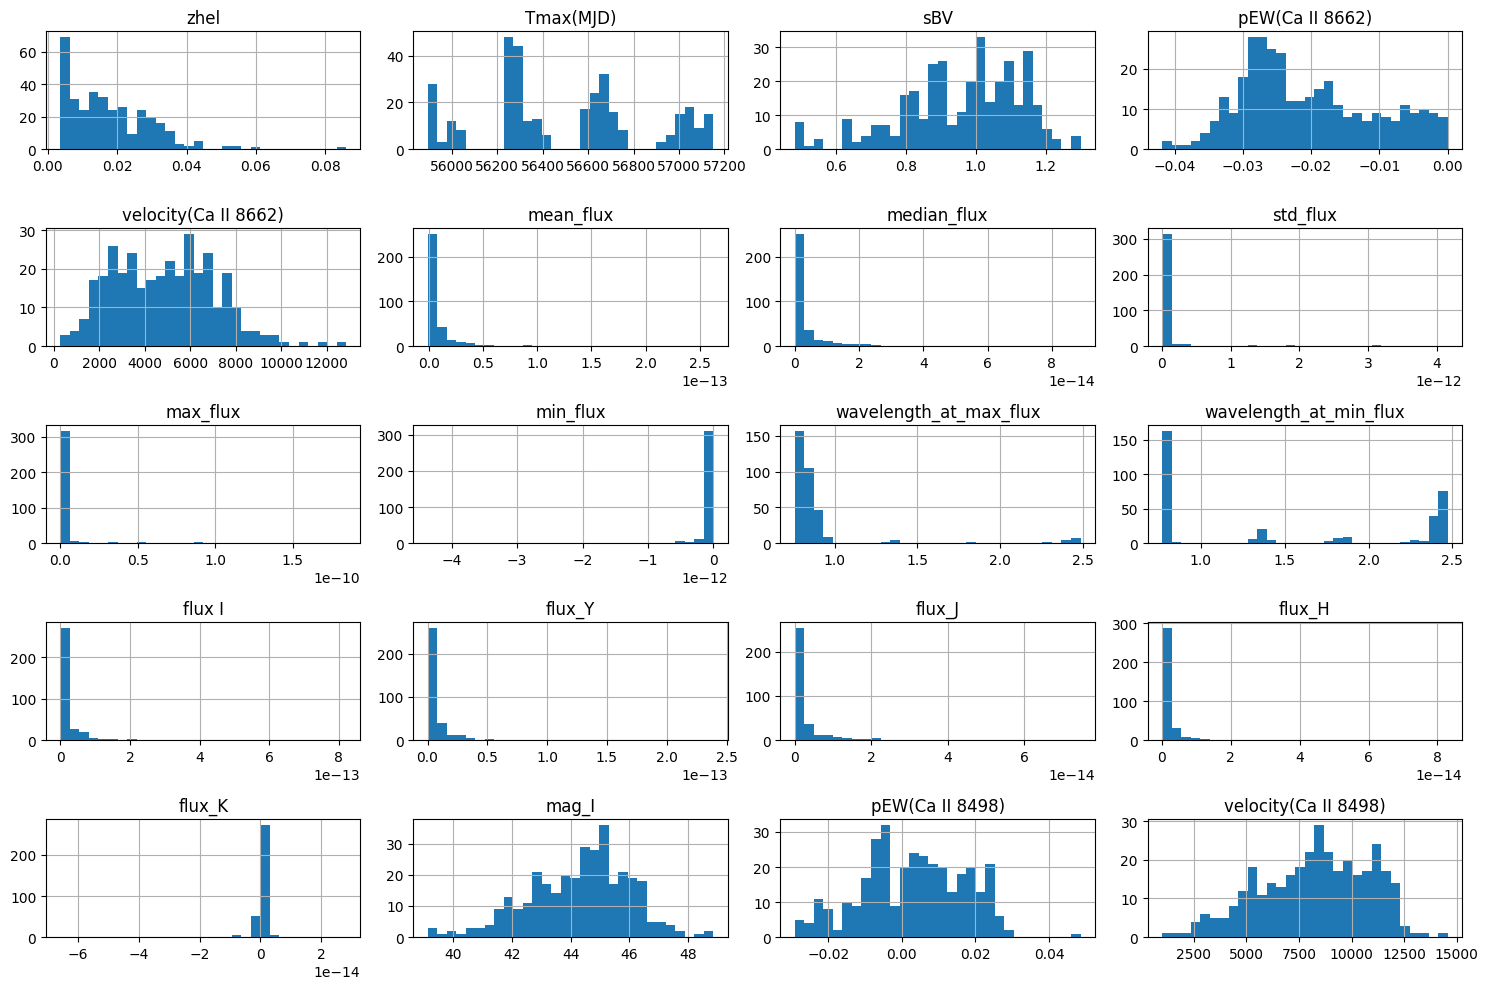

In [8]:
features_to_plot = [col for col in features_df_cleaned.columns if col not in ['filename']]


features_df_cleaned[features_to_plot].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [9]:
# Not selecting the features that shows extreme skewness and narrow ranges
spectral_data = features_df_cleaned[['filename','zhel','Tmax(MJD)','sBV','pEW(Ca II 8662)','velocity(Ca II 8662)','pEW(Ca II 8498)','velocity(Ca II 8498)','mag_I']]
spectral_data

,filename,zhel,Tmax(MJD),sBV,pEW(Ca II 8662),velocity(Ca II 8662),pEW(Ca II 8498),velocity(Ca II 8498),mag_I
0,ASAS14ad_20140208_fire,0.0264,56692.70,1.013,-0.021491,2218.194923,0.008005,6334.992694,46.304623
1,ASAS14ad_20140215_fire,0.0264,56692.70,1.013,-0.033441,4001.070175,0.019158,8782.921367,46.442950
2,ASAS14ad_20140222_fire,0.0264,56692.70,1.013,-0.036000,12846.600390,0.048528,14570.428568,43.640522
3,ASAS14ad_20140227_fire,0.0264,56692.70,1.013,-0.028717,8010.903497,0.029929,10759.048906,42.908882
4,ASAS14ad_20140310_fire,0.0264,56692.70,1.013,-0.031417,7681.908153,0.026547,8914.790857,44.656331
...,...,...,...,...,...,...,...,...,...
334,CSP15aae_20150307_fire,0.0162,57076.02,0.505,-0.026718,8331.868522,0.017189,9944.054637,45.024021
335,SNhunt281_20150402_fire,0.0041,57112.67,0.692,-0.014711,4536.046290,-0.028241,7591.256323,40.421597
336,SNhunt281_20150407_fire,0.0041,57112.67,0.692,-0.025012,5063.755896,-0.022577,8758.260278,43.056929
337,SNhunt281_20150412_fire,0.0041,57112.67,0.692,-0.029215,5443.183293,-0.015488,9261.624239,43.869802


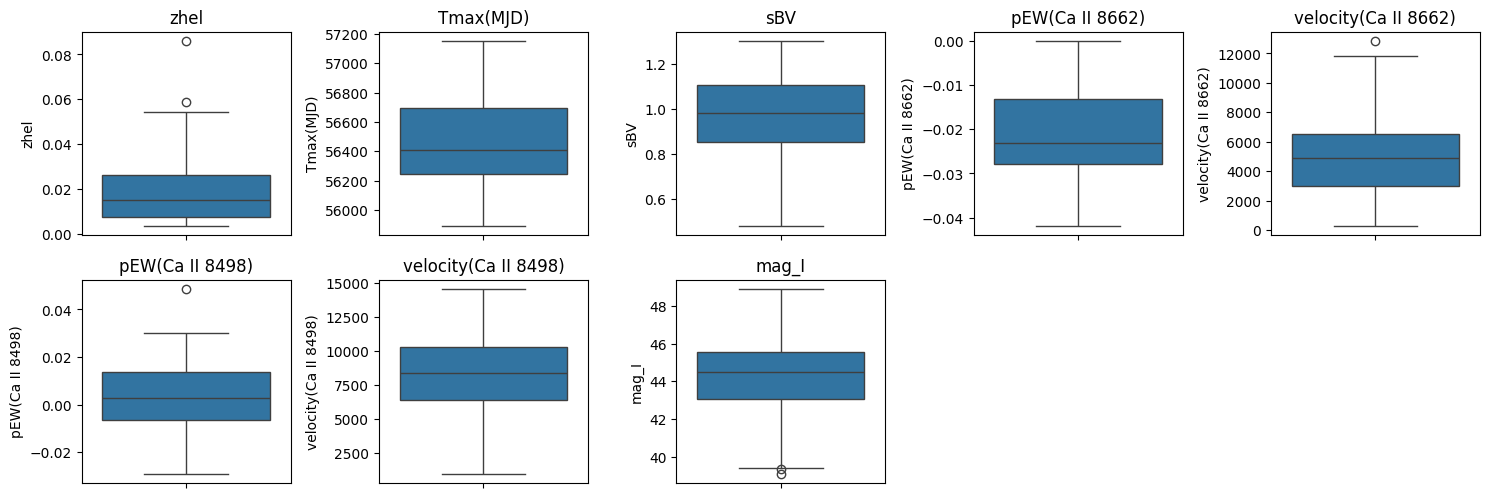

In [11]:
features_to_plot = [col for col in spectral_data.columns if col not in ['filename']]
plt.figure(figsize=(15, 10))
for i, column in enumerate(features_to_plot):
    plt.subplot(4, 5, i + 1)
    sns.boxplot(y=spectral_data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

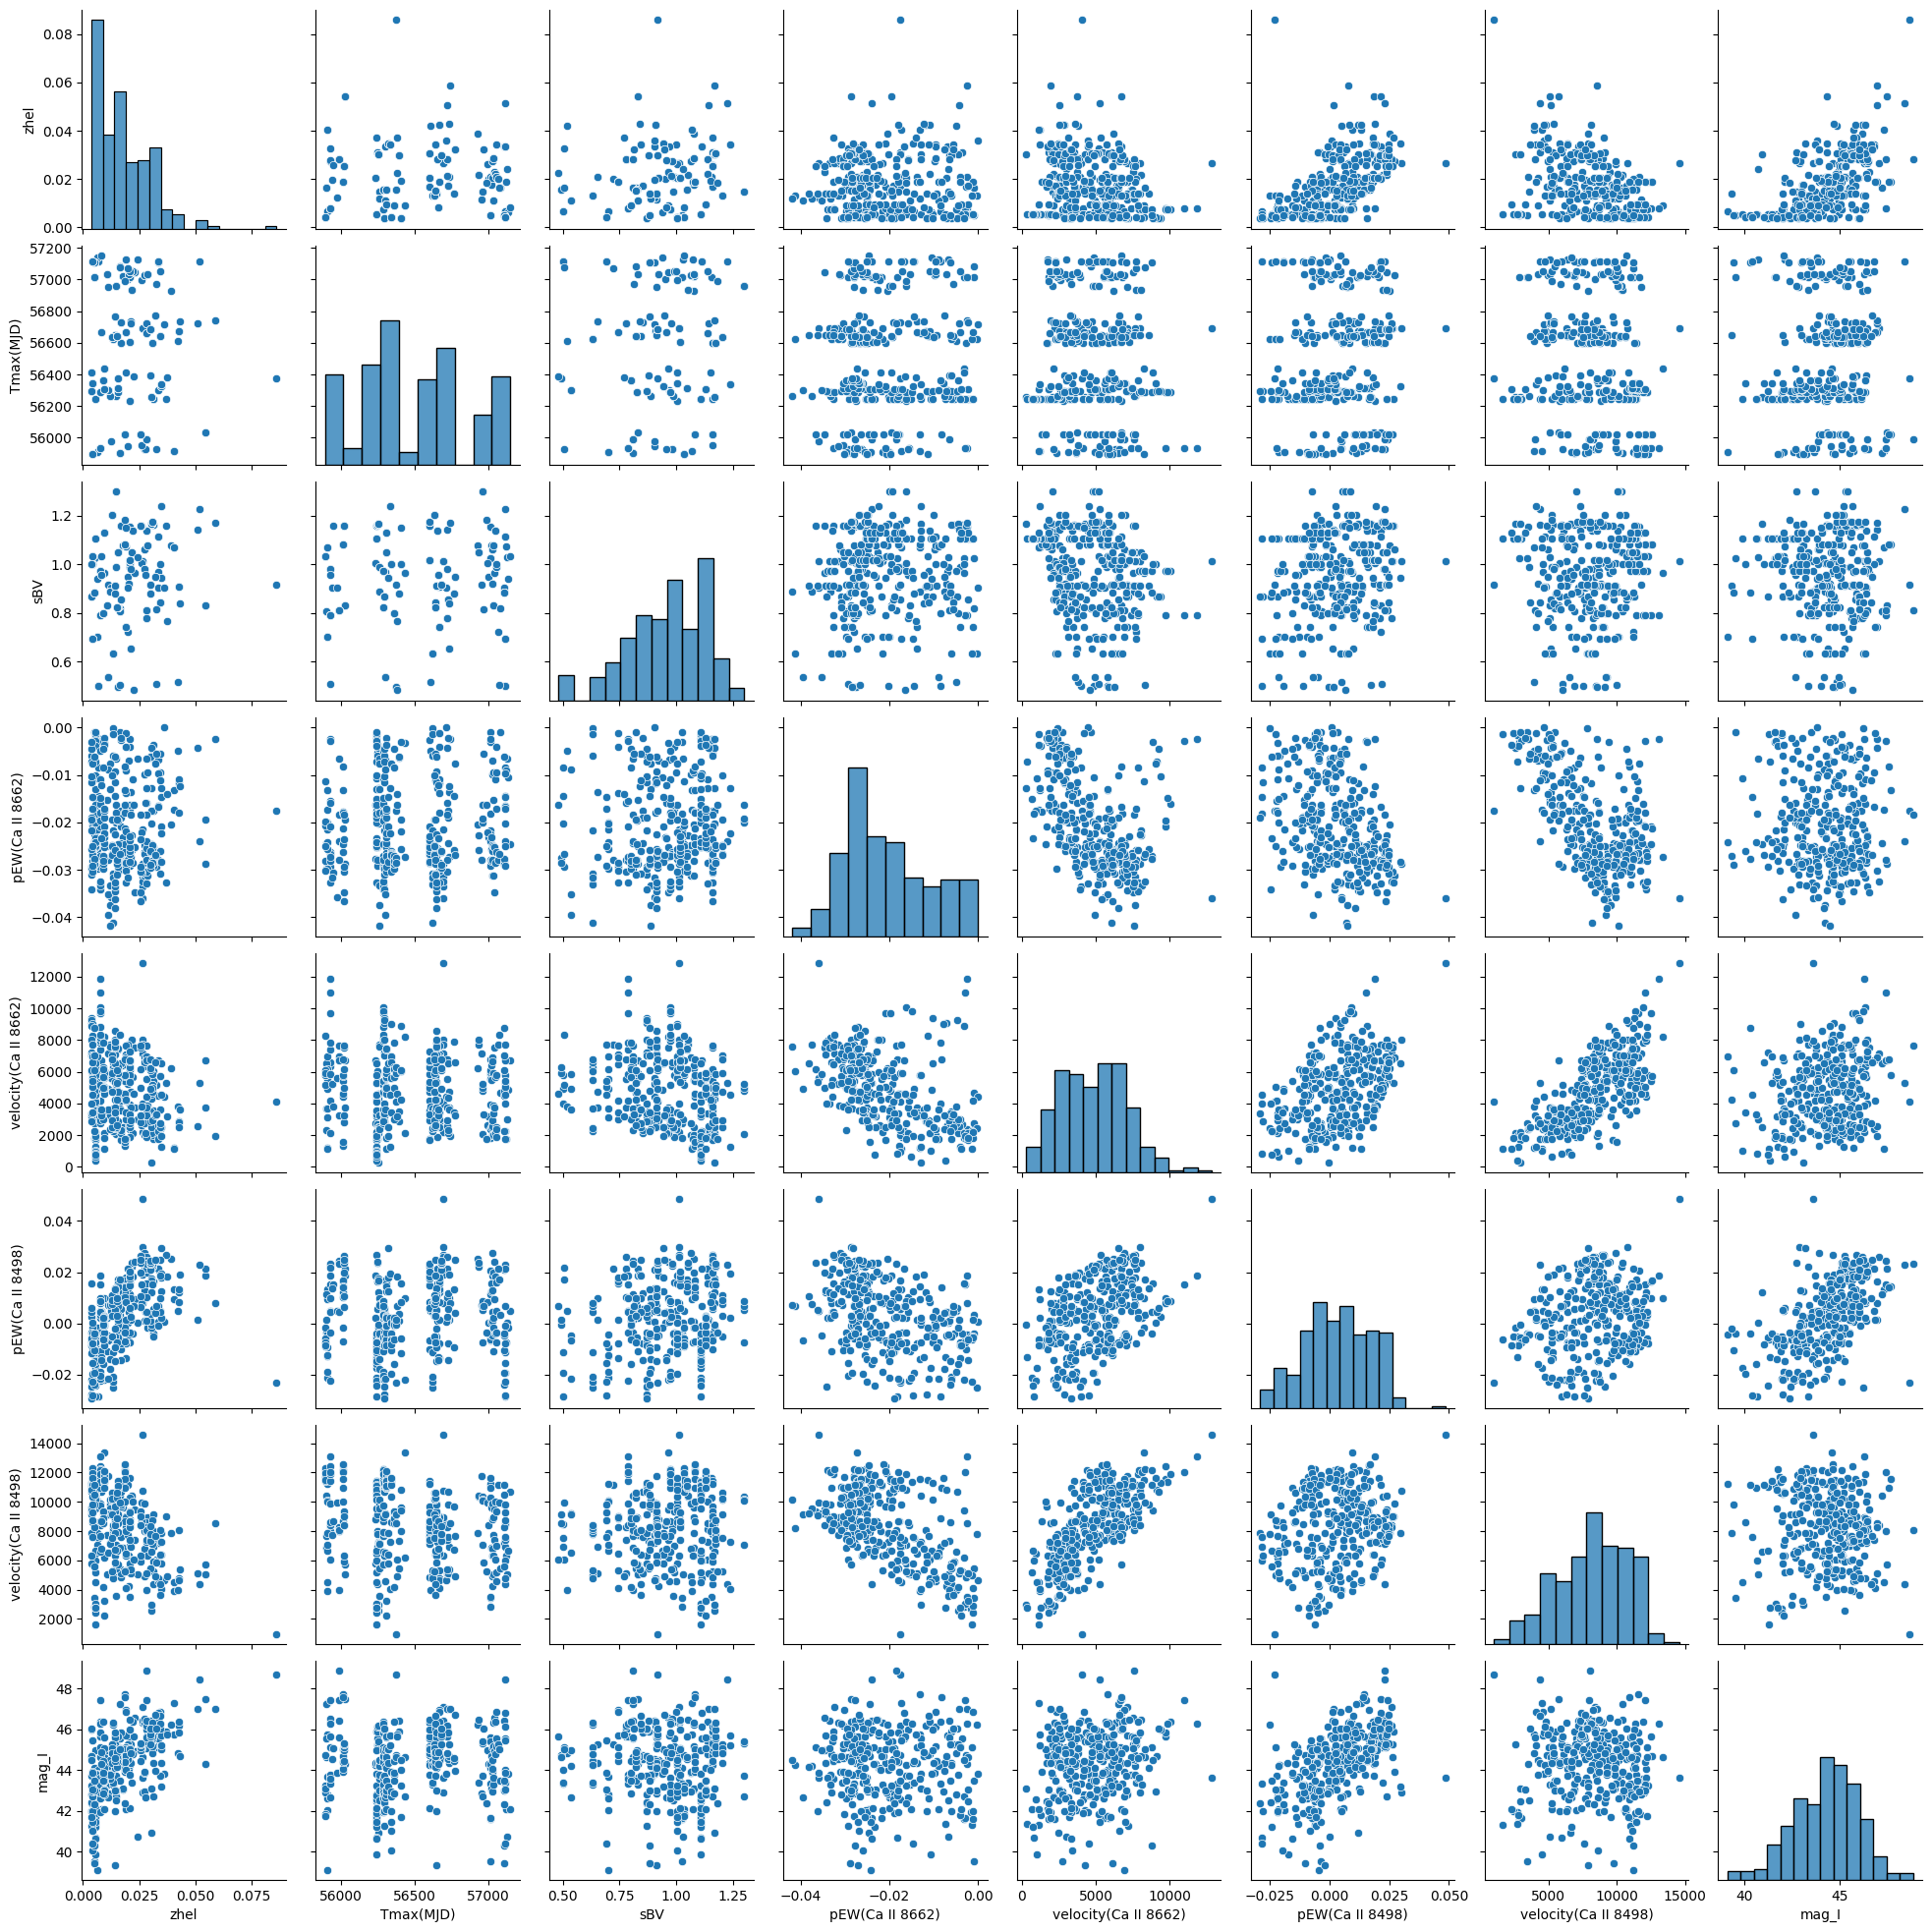

In [12]:

sns.pairplot(spectral_data[features_to_plot])
plt.show()

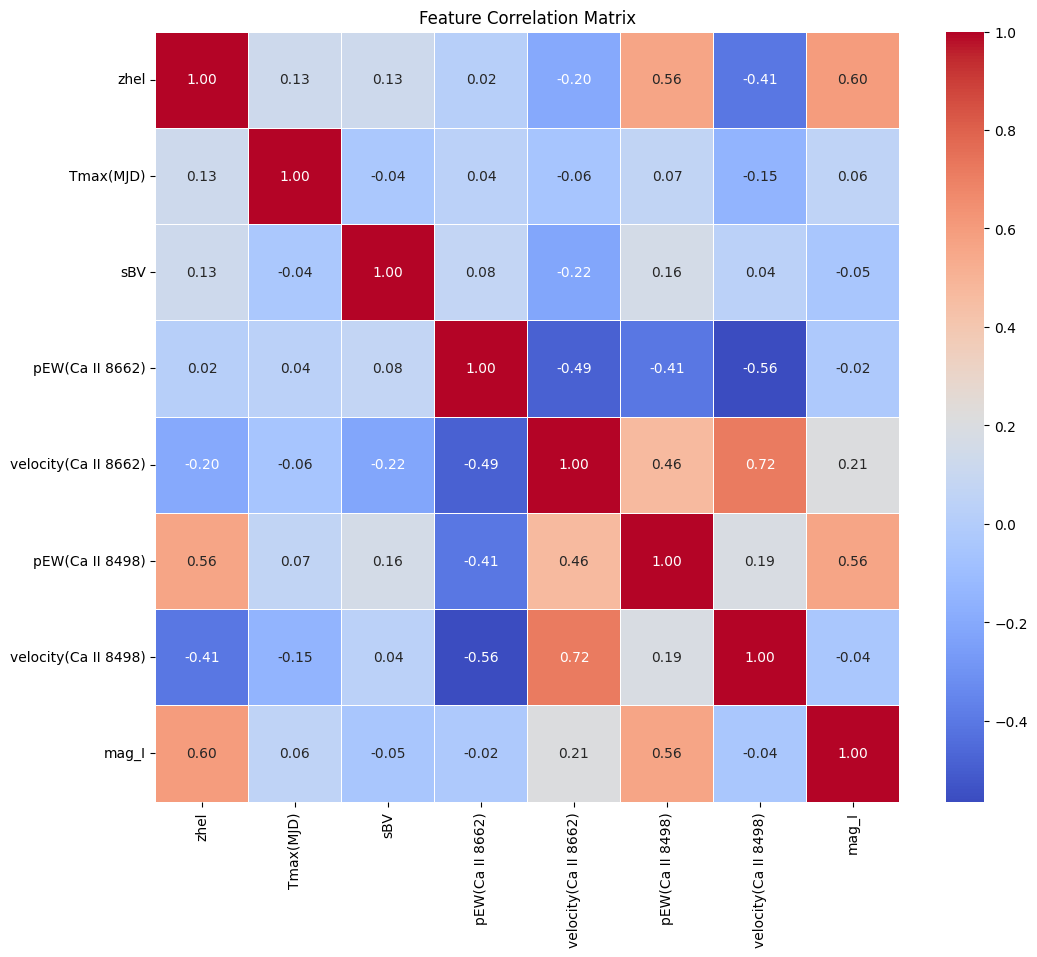

In [13]:
correlation_matrix = spectral_data[features_to_plot].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Discarding 'velocity(Ca II 8498)' feature beacause of its strong positive correlation with 'velocity(Ca II 8662)' and other features

**USING PCA TO UNDERSTAND FEATURE IMPORTANCE**

PCA Loadings (Feature Importance):
                            PC1       PC2       PC3       PC4       PC5  \
zhel                  0.432517  0.486925  0.038783  0.112441 -0.388071   
Tmax(MJD)             0.071841  0.178104  0.603786 -0.762951  0.110576   
sBV                   0.022320  0.315733 -0.740146 -0.448059  0.297070   
pEW(Ca II 8662)      -0.298164  0.496423  0.171996  0.281485  0.630682   
velocity(Ca II 8662)  0.322227 -0.579115  0.033961 -0.011340  0.517881   
pEW(Ca II 8498)       0.600753 -0.013129 -0.154385 -0.109324  0.053043   
mag_I                 0.503620  0.222517  0.177627  0.336440  0.283107   

                           PC6       PC7  
zhel                  0.291276  0.571179  
Tmax(MJD)            -0.064208  0.010835  
sBV                  -0.197453  0.154927  
pEW(Ca II 8662)       0.395795 -0.037846  
velocity(Ca II 8662)  0.185642  0.506804  
pEW(Ca II 8498)       0.470485 -0.615603  
mag_I                -0.677919 -0.111286  


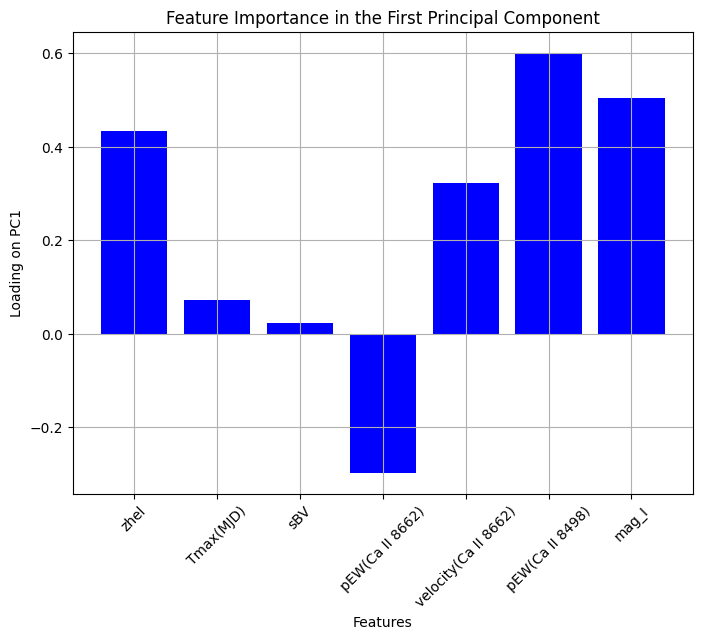

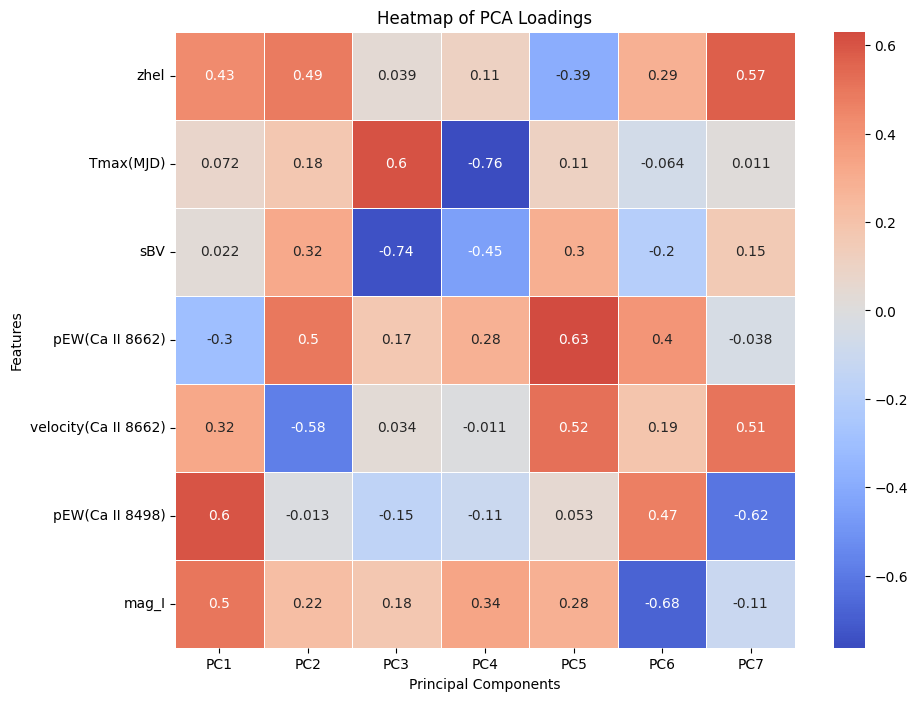

In [14]:

# Select the relevant columns
features = ['zhel', 'Tmax(MJD)','sBV', 'pEW(Ca II 8662)', 'velocity(Ca II 8662)', 'pEW(Ca II 8498)', 'mag_I']
X = spectral_data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#  Analyze the PCA components (loadings)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)
print("PCA Loadings (Feature Importance):\n", loadings)

# Visualize the feature importance in the first principal component
plt.figure(figsize=(8, 6))
plt.bar(loadings.index, loadings['PC1'], color='blue')
plt.title('Feature Importance in the First Principal Component')
plt.xlabel('Features')
plt.ylabel('Loading on PC1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot a heatmap of the PCA loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()



Discarded sBV feature for its lower value in PC1

# **K-MEANS IMPLEMENTAION**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

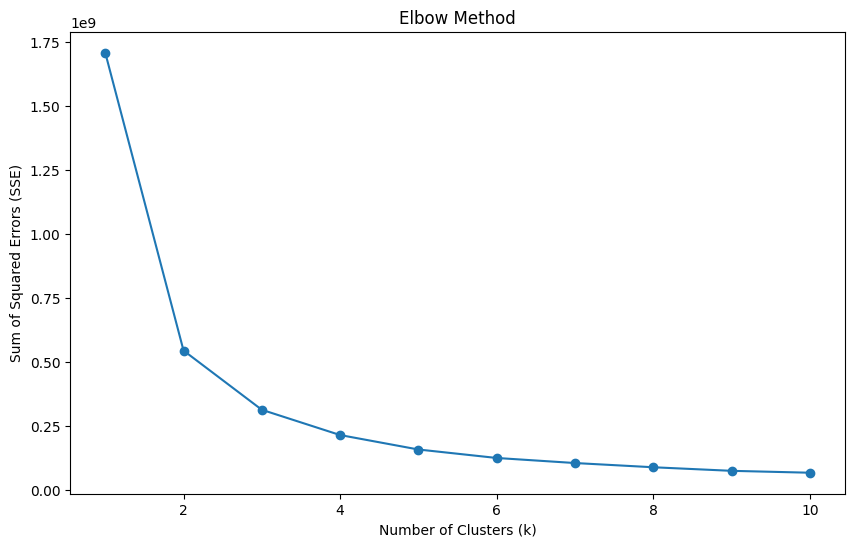

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

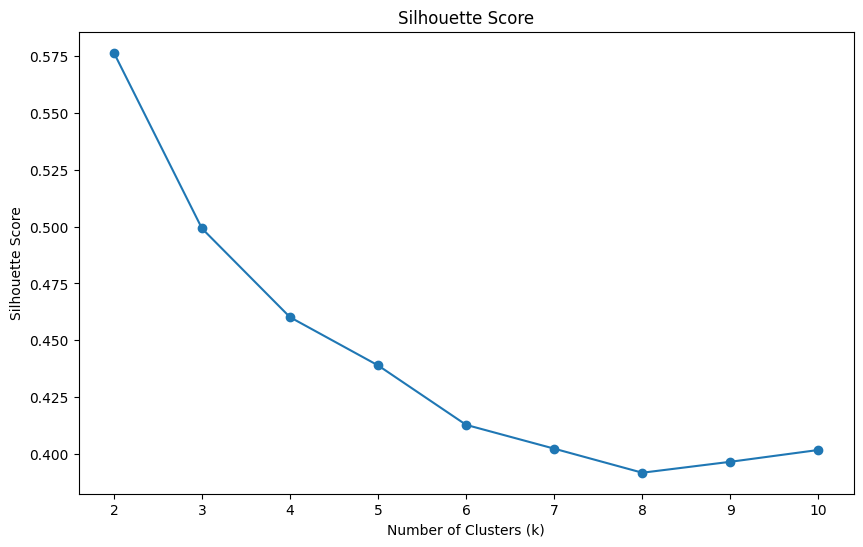

In [16]:

selected_features = spectral_data[['zhel','Tmax(MJD)','pEW(Ca II 8662)','velocity(Ca II 8662)','pEW(Ca II 8498)','mag_I']]

# Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_features)
    silhouette_scores.append(silhouette_score(selected_features, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-17-8ecbc9a2b9bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features['Cluster'] = kmeans.fit_predict(selected_features)


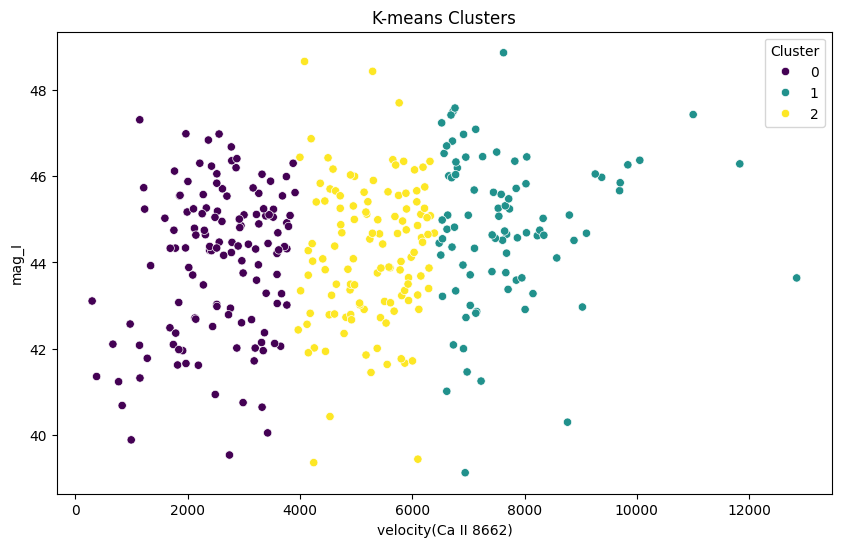

In [17]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
selected_features['Cluster'] = kmeans.fit_predict(selected_features)
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='Cluster', data=selected_features, palette='viridis')

# Set the title of the plot
plt.title('K-means Clusters')

# Show the plot
plt.show()

# **OPTIMIZATION OF K-MEANS**

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}
Best Silhouette Score:  0.24994916086628524


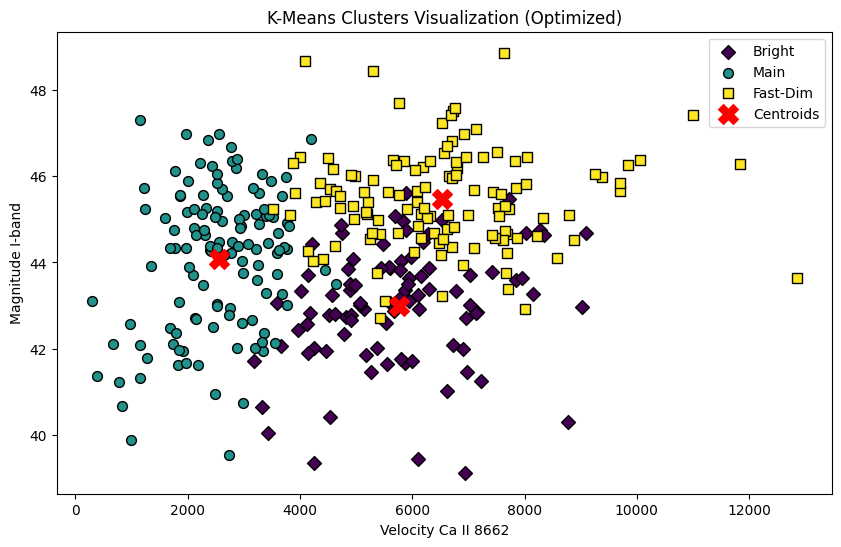

In [29]:

# Step 1: Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(selected_features)

# Step 2: Define the parameter grid
param_grid = {
    'n_clusters': range(2, 4),  # Search for k in the range of 2 to 3 (Based on elbow method)
    'init': ['k-means++', 'random'],  # Initialization methods
    'n_init': [10, 20, 30],  # Number of initializations to test
    'max_iter': [300, 500, 1000]  # Different max iterations
}

# Initialize KMeans object
kmeans = KMeans(random_state=42)

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(kmeans, param_grid, cv=5, n_jobs=-1, verbose=1)

# Step 4: Fit the grid search to the normalized data
grid_search.fit(normalized_features)

# Get the best estimator
best_kmeans = grid_search.best_estimator_

# Fit the best KMeans model on normalized data
labels = best_kmeans.fit_predict(normalized_features)

# Calculate the silhouette score for the best model
best_silhouette_score = silhouette_score(normalized_features, labels)

# Print the best parameters and the silhouette score
print("Best parameters found: ", grid_search.best_params_)
print("Best Silhouette Score: ", best_silhouette_score)

# Define custom names for clusters
cluster_names = {
    0: 'Bright',
    1: 'Main',
    2: 'Fast-Dim',
}

# Step 5: Plot the clusters
plt.figure(figsize=(10, 6))

# Inverse transform the normalized features and centroids back to original scale
original_features = scaler.inverse_transform(normalized_features)
centroids_original = scaler.inverse_transform(best_kmeans.cluster_centers_)

# Unique labels
unique_labels = np.unique(labels)

# Scatter plot of the data points colored by their cluster labels
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Define markers for each cluster
markers = ['D', 'o', 's']

for color, label, marker in zip(colors, unique_labels, markers):
    plt.scatter(original_features[labels == label, 3], original_features[labels == label, 5],
                c=color.reshape(1, -1), label=cluster_names.get(label, f'Cluster {label}'),
                s=50, marker=marker, edgecolor='black')

# Plot the cluster centroids (on the original scale)
plt.scatter(centroids_original[:, 3], centroids_original[:, 5], c='red', s=200, marker='X', label='Centroids')

# Add title and labels
plt.title('K-Means Clusters Visualization (Optimized)')
plt.xlabel('Velocity Ca II 8662')
plt.ylabel('Magnitude I-band')
plt.legend()

plt.show()


# **GAUSSIAN MIXTURE MODEL IMPLEMENTAION**

<ipython-input-30-478df8fd4404>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['cluster'] = gmm.predict(X_scaled)


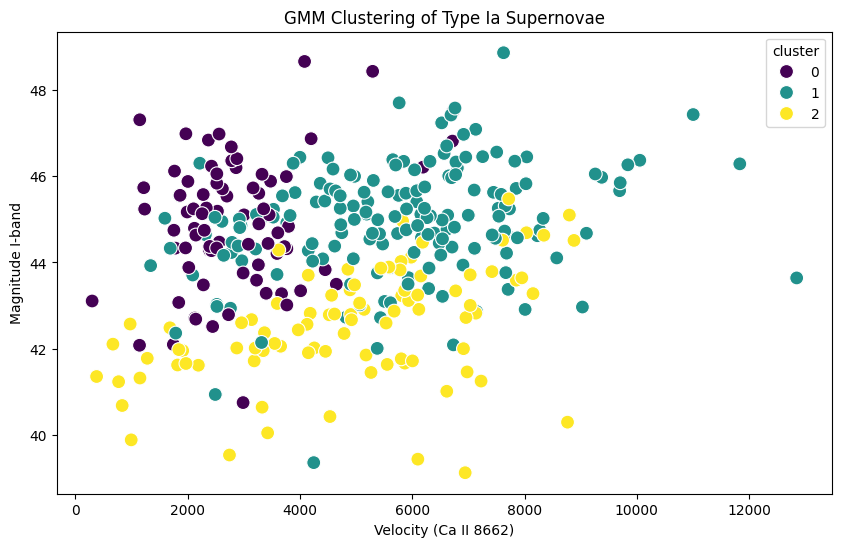

In [30]:

# Extract relevant features for clustering
selected_features = spectral_data[['zhel','Tmax(MJD)','pEW(Ca II 8662)','velocity(Ca II 8662)','pEW(Ca II 8498)','mag_I']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_features)

# Fit Gaussian Mixture Model with an appropriate number of clusters
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
spectral_data['cluster'] = gmm.predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='cluster', data=spectral_data, palette='viridis', s=100)
plt.title('GMM Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II 8662)')
plt.ylabel('Magnitude I-band')
plt.show()


# **OPTIMIZED GMM**

**USING covariance_type = 'full'**

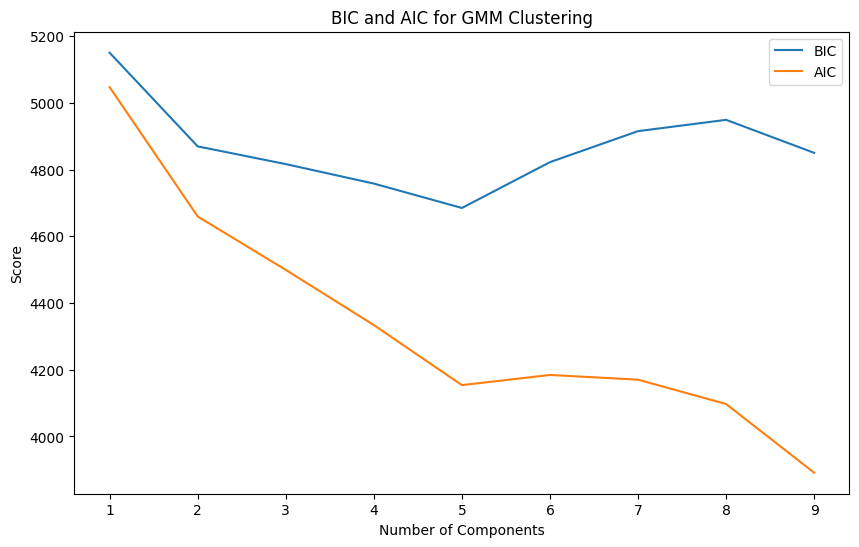

In [31]:

# Extract relevant features for clustering
selected_features = spectral_data[['zhel', 'Tmax(MJD)', 'pEW(Ca II 8662)', 'velocity(Ca II 8662)', 'pEW(Ca II 8498)', 'mag_I']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_features)

# Determine the optimal number of components using BIC and AIC, and track log-likelihood
n_components = range(1, 10)
bic_scores = []
aic_scores = []
log_likelihoods = []

for n in n_components:
    # Initialize GMM with regularization and different init method
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='full',
                          max_iter=500, tol=1e-4, reg_covar=1e-6, init_params='kmeans')
    gmm.fit(X_scaled)

    # Append scores
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))
    log_likelihoods.append(gmm.lower_bound_)

# Plot BIC, AIC, and log-likelihood to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_components, bic_scores, label='BIC')
plt.plot(n_components, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM Clustering')
plt.legend()
plt.show()




Log-Likelihood of the fitted GMM: -6.42919567243934
Silhouette of the fitted GMM: 0.20016083249929376


<ipython-input-32-e66672bc7f48>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['cluster'] = gmm_optimal.predict(X_scaled)


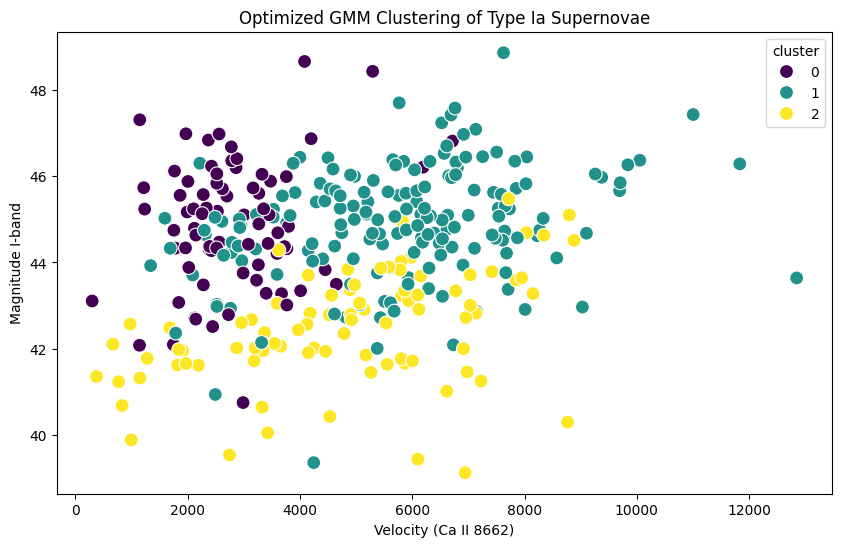

In [32]:
# Fit the GMM model with the optimal number of components
gmm_optimal = GaussianMixture(n_components=3, random_state=42, covariance_type='full',
                              max_iter=500, tol=1e-4, reg_covar=1e-6, init_params='kmeans')
gmm_optimal.fit(X_scaled)

# Retrieve the log-likelihood of the fitted model
log_likelihood = gmm_optimal.lower_bound_
print(f"Log-Likelihood of the fitted GMM: {log_likelihood}")
labels = gmm_optimal.fit_predict(X_scaled)
best_silhouette_score = silhouette_score(X_scaled, labels)

print(f"Silhouette of the fitted GMM: {best_silhouette_score}")
# Predict cluster labels
spectral_data['cluster'] = gmm_optimal.predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='cluster', data=spectral_data, palette='viridis', s=100)
plt.title('Optimized GMM Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II 8662)')
plt.ylabel('Magnitude I-band')
plt.show()

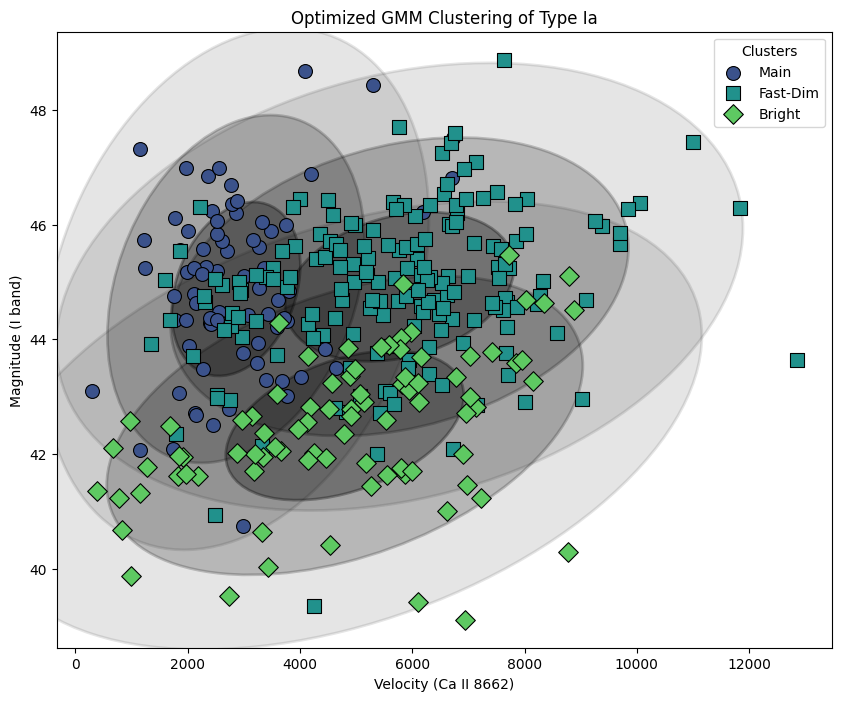

In [34]:
# Inverse transform the means back to original space
means_original_space = scaler.inverse_transform(gmm_optimal.means_)

# Transform the covariances back to the original scale
covariances_original_space = []
for i in range(gmm_optimal.n_components):
    # Scale the covariance matrices by the square of the standard deviations
    cov_matrix_scaled = gmm_optimal.covariances_[i]
    scaling_factors = scaler.scale_
    cov_matrix_original = np.diag(scaling_factors) @ cov_matrix_scaled @ np.diag(scaling_factors)
    covariances_original_space.append(cov_matrix_original)

# Function to draw ellipses
def draw_ellipse(mean, cov_matrix, ax, color='black'):
    """Draw ellipses representing the covariance matrix at different scales (1σ, 2σ, 3σ)."""
    # Eigen decomposition of the covariance matrix
    v, w = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues and eigenvectors
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]

    # Calculate the angle of the ellipse
    angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))

    # Create ellipses at 1σ, 2σ, and 3σ levels
    for nsig, alpha in zip([1, 2, 3], [0.3, 0.2, 0.1]):
        width, height = 2 * np.sqrt(v) * nsig
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha, lw=2)
        ax.add_patch(ellipse)

# Define custom names for each cluster
cluster_names = ['Main', 'Fast-Dim', 'Bright']

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Get the indices for 'velocity(Ca II 8662)' and 'mag_I'
velocity_idx = selected_features.columns.get_loc('velocity(Ca II 8662)')
mag_i_idx = selected_features.columns.get_loc('mag_I')

# Draw ellipses for each GMM component (cluster)
for i in range(gmm_optimal.n_components):
    # Extract the mean and covariance for the cluster in original space
    mean_original = means_original_space[i, [velocity_idx, mag_i_idx]]
    cov_matrix_original = covariances_original_space[i][[velocity_idx, mag_i_idx], :][:, [velocity_idx, mag_i_idx]]  # Extract the 2x2 covariance matrix for these features

    # Draw the ellipse (keeping the original color scheme)
    draw_ellipse(mean_original, cov_matrix_original, ax, color='black')

# Define a color gradient for the clusters
colors = sns.color_palette("viridis", n_colors=gmm_optimal.n_components)

# Define markers for each cluster
markers = ['o', 's', 'D']

# Scatter plot for each cluster
for i in range(gmm_optimal.n_components):
    cluster_data = spectral_data[spectral_data['cluster'] == i]
    sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', data=cluster_data,
                    color=colors[i], marker=markers[i], s=100, ax=ax,
                    edgecolor='black', label=cluster_names[i], zorder=10)

# Adding padding to the plot to make sure all points and ellipses are fully visible
x_padding = (spectral_data['velocity(Ca II 8662)'].max() - spectral_data['velocity(Ca II 8662)'].min()) * 0.05
y_padding = (spectral_data['mag_I'].max() - spectral_data['mag_I'].min()) * 0.05

plt.xlim(spectral_data['velocity(Ca II 8662)'].min() - x_padding, spectral_data['velocity(Ca II 8662)'].max() + x_padding)
plt.ylim(spectral_data['mag_I'].min() - y_padding, spectral_data['mag_I'].max() + y_padding)

# Set plot labels and title
ax.set_title('Optimized GMM Clustering of Type Ia')
ax.set_xlabel('Velocity (Ca II 8662)')
ax.set_ylabel('Magnitude (I band)')

# Add a legend with custom cluster names
ax.legend(title='Clusters')

plt.show()


**USING covariance_type = 'spherical'**

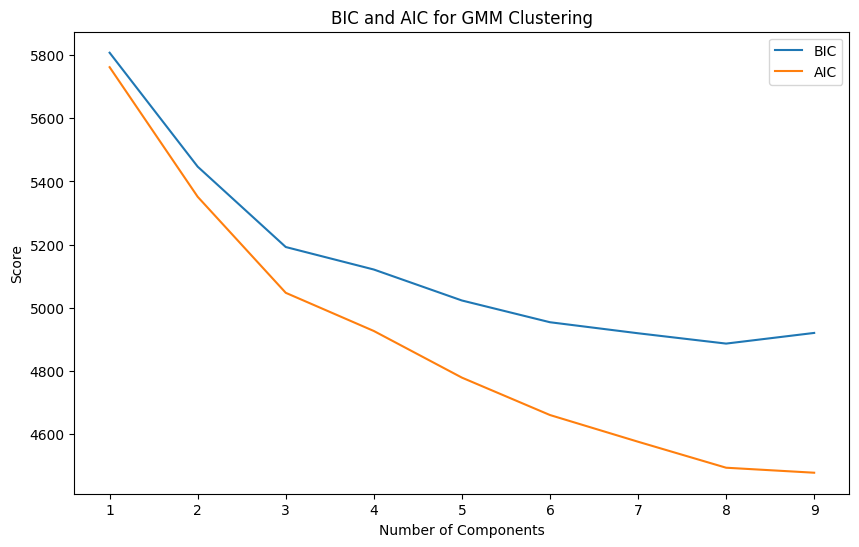

In [35]:

# Extract relevant features for clustering
selected_features = spectral_data[['zhel', 'Tmax(MJD)', 'pEW(Ca II 8662)', 'velocity(Ca II 8662)', 'pEW(Ca II 8498)', 'mag_I']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_features)

# Determine the optimal number of components using BIC and AIC, and track log-likelihood
n_components = range(1, 10)
bic_scores = []
aic_scores = []
log_likelihoods = []

for n in n_components:
    # Initialize GMM with regularization and different init method
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='diag',
                          max_iter=500, tol=1e-4, reg_covar=1e-6, init_params='kmeans')
    gmm.fit(X_scaled)

    # Append scores
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))
    log_likelihoods.append(gmm.lower_bound_)

# Plot BIC, AIC, and log-likelihood to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_components, bic_scores, label='BIC')
plt.plot(n_components, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM Clustering')
plt.legend()
plt.show()




Log-Likelihood of the fitted GMM: -7.88125344770465
Silhouette of the fitted GMM: 0.24737842109440397


<ipython-input-36-9e1df80934cf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['cluster'] = gmm_optimal.predict(X_scaled)


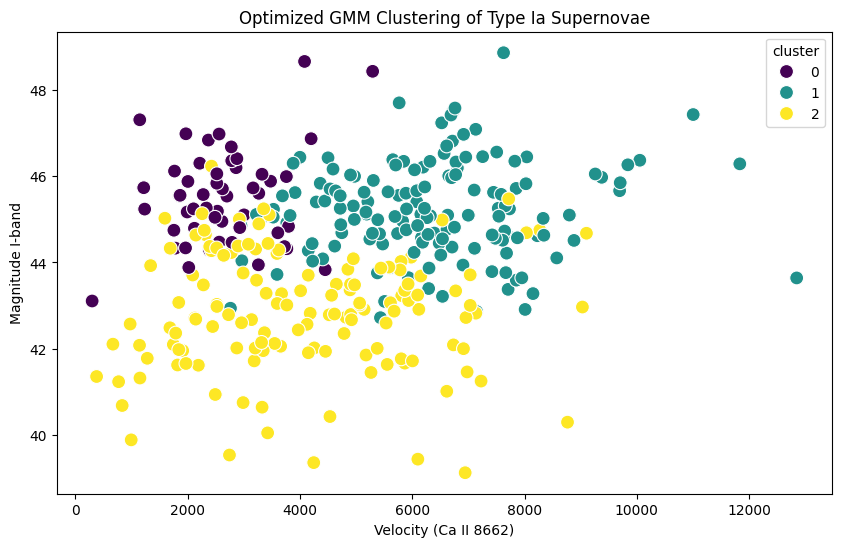

In [36]:
# Fit the GMM model with the optimal number of components
gmm_optimal = GaussianMixture(n_components=3, random_state=42, covariance_type='spherical',
                              max_iter=500, tol=1e-4, reg_covar=1e-6, init_params='kmeans')
gmm_optimal.fit(X_scaled)

# Retrieve the log-likelihood of the fitted model
log_likelihood = gmm_optimal.lower_bound_
print(f"Log-Likelihood of the fitted GMM: {log_likelihood}")
labels = gmm_optimal.fit_predict(X_scaled)
best_silhouette_score = silhouette_score(X_scaled, labels)

print(f"Silhouette of the fitted GMM: {best_silhouette_score}")

# Predict cluster labels
spectral_data['cluster'] = gmm_optimal.predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='cluster', data=spectral_data, palette='viridis', s=100)
plt.title('Optimized GMM Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II 8662)')
plt.ylabel('Magnitude I-band')
plt.show()

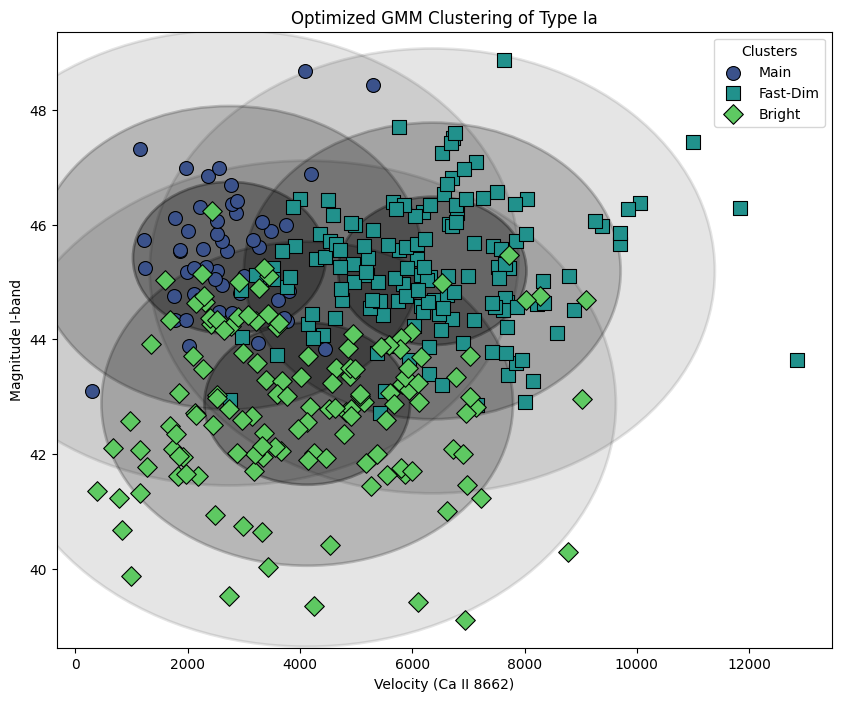

In [37]:
# Inverse transform the means back to original space
means_original_space = scaler.inverse_transform(gmm_optimal.means_)

# Transform the covariances back to the original scale
covariances_original_space = []
for i in range(gmm_optimal.n_components):
    # Scale the scalar covariance by the square of the standard deviations
    cov_matrix_scaled = gmm_optimal.covariances_[i]
    scaling_factors = scaler.scale_
    cov_matrix_original = cov_matrix_scaled * np.diag(scaling_factors ** 2)  # Create a diagonal matrix
    covariances_original_space.append(cov_matrix_original)


# Function to draw ellipses
def draw_ellipse(mean, cov_matrix, ax, color='black'):
    """Draw ellipses representing the covariance matrix at different scales (1σ, 2σ, 3σ)."""
    # Eigen decomposition of the covariance matrix
    v, w = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues and eigenvectors
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]

    # Calculate the angle of the ellipse
    angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))

    # Create ellipses at 1σ, 2σ, and 3σ levels
    for nsig, alpha in zip([1, 2, 3], [0.3, 0.2, 0.1]):
        width, height = 2 * np.sqrt(v) * nsig
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha, lw=2)
        ax.add_patch(ellipse)

# Define custom names for each cluster
cluster_names = ['Main', 'Fast-Dim', 'Bright']

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Get the indices for 'velocity(Ca II 8662)' and 'mag_I'
velocity_idx = selected_features.columns.get_loc('velocity(Ca II 8662)')
mag_i_idx = selected_features.columns.get_loc('mag_I')

# Draw ellipses for each GMM component (cluster)
for i in range(gmm_optimal.n_components):
    # Extract the mean and covariance for the cluster in original space
    mean_original = means_original_space[i, [velocity_idx, mag_i_idx]]
    cov_matrix_original = covariances_original_space[i][[velocity_idx, mag_i_idx], :][:, [velocity_idx, mag_i_idx]]  # Extract the 2x2 covariance matrix for these features

    # Draw the ellipse (keeping the original color scheme)
    draw_ellipse(mean_original, cov_matrix_original, ax, color='black')

# Define a color gradient for the clusters
colors = sns.color_palette("viridis", n_colors=gmm_optimal.n_components)

# Define markers for each cluster
markers = ['o', 's', 'D']
# Scatter plot for each cluster with different colors and markers
for i in range(gmm_optimal.n_components):
    cluster_data = spectral_data[spectral_data['cluster'] == i]
    sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', data=cluster_data,
                    color=colors[i], marker=markers[i], s=100, ax=ax,
                    edgecolor='black', label=cluster_names[i], zorder=10)

# Adding padding to the plot to make sure all points and ellipses are fully visible
x_padding = (spectral_data['velocity(Ca II 8662)'].max() - spectral_data['velocity(Ca II 8662)'].min()) * 0.05
y_padding = (spectral_data['mag_I'].max() - spectral_data['mag_I'].min()) * 0.05

plt.xlim(spectral_data['velocity(Ca II 8662)'].min() - x_padding, spectral_data['velocity(Ca II 8662)'].max() + x_padding)
plt.ylim(spectral_data['mag_I'].min() - y_padding, spectral_data['mag_I'].max() + y_padding)

# Set plot labels and title
ax.set_title('Optimized GMM Clustering of Type Ia')
ax.set_xlabel('Velocity (Ca II 8662)')
ax.set_ylabel('Magnitude I-band')

# Add a legend with custom cluster names
ax.legend(title='Clusters')

plt.show()


# **DBSCAN IMPLEMENTAION**

<ipython-input-39-66618b96f54a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['dbscan_cluster'] = [cluster_names[label] for label in labels]


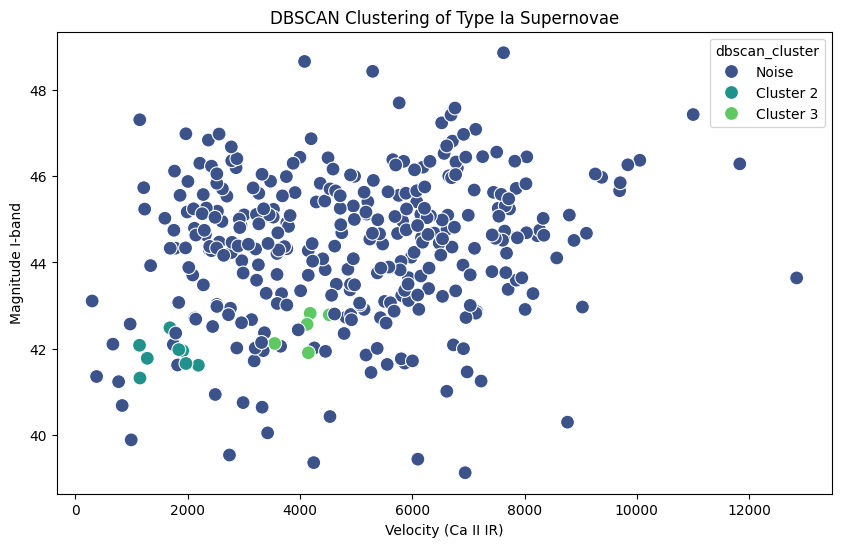

In [39]:

# Extract relevant features for clustering
X = spectral_data[['zhel', 'Tmax(MJD)', 'sBV', 'pEW(Ca II 8662)', 'velocity(Ca II 8662)', 'pEW(Ca II 8498)', 'mag_I']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit DBSCAN model
# eps and min_samples need to be tuned; these are just example values
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Map DBSCAN labels to clusters and 'Noise'
unique_labels = np.unique(labels)
cluster_names = {label: f'Cluster {i+1}' for i, label in enumerate(unique_labels) if label != -1}
cluster_names[-1] = 'Noise'

# Apply the mapping to create a new column in the DataFrame
spectral_data['dbscan_cluster'] = [cluster_names[label] for label in labels]

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='dbscan_cluster', palette='viridis', data=spectral_data, s=100)
plt.title('DBSCAN Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II IR)')
plt.ylabel('Magnitude I-band')

plt.show()

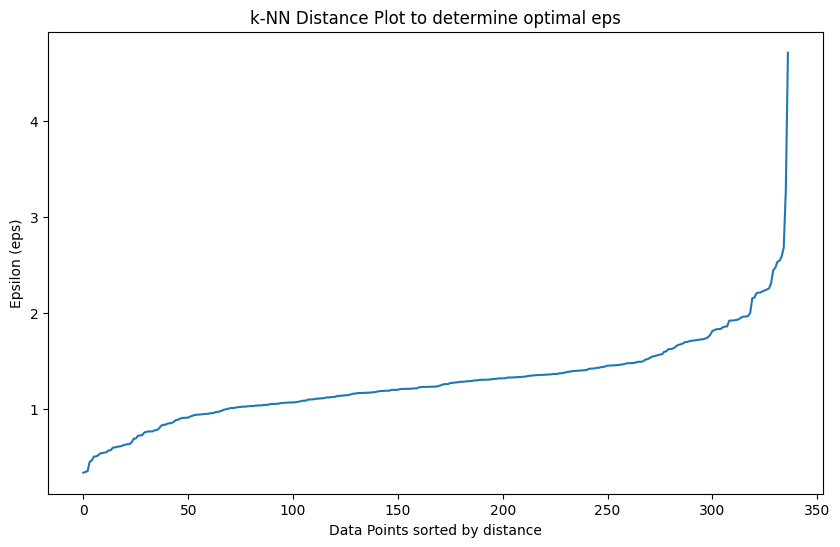

In [40]:

# Fit NearestNeighbors to the data
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot the distances
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (eps)')
plt.title('k-NN Distance Plot to determine optimal eps')
plt.show()


# **OPTIMIZED DBSCAN MODEL**

Best Silhouette Score: 0.49243826804425384
Best params: {'eps': 2.7999999999999994, 'min_samples': 2}


<ipython-input-43-f8bc19c014c4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['DBSCAN'] = np.where(labels == -1, 'Noise', 'Cluster 1')


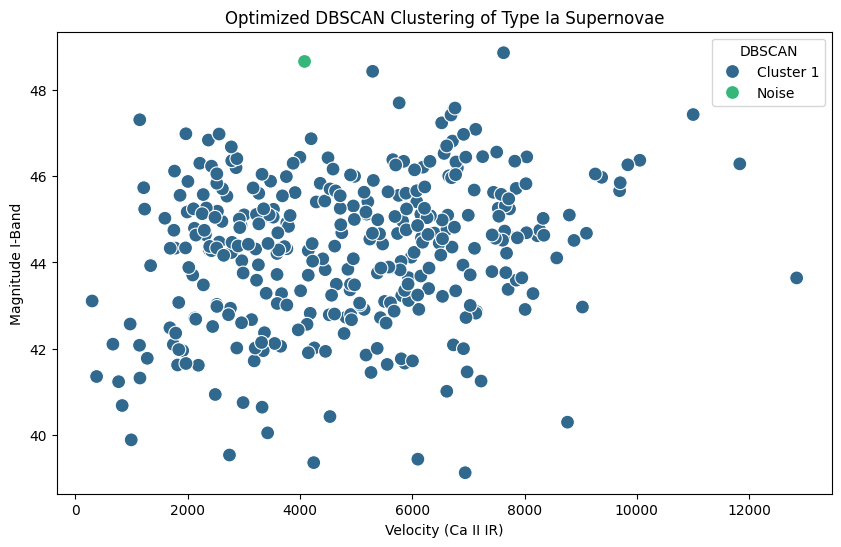

In [43]:
# Define the range of eps and min_samples values
eps_values = np.arange(0.5, 5, 0.1)
min_samples_values = range(2, 10)

best_score = -1
best_params = None

# Iterate over all combinations of eps and min_samples to find the best parameters
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        if len(set(labels)) > 1:  # Avoid calculating the score when there's only one cluster
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# Output the best parameters and silhouette score
print(f"Best Silhouette Score: {best_score}")
print(f"Best params: {best_params}")

# Refit the DBSCAN model with the best parameters
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(X_scaled)

# Map the labels to 'Cluster 1' and 'Noise'
spectral_data['DBSCAN'] = np.where(labels == -1, 'Noise', 'Cluster 1')

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity(Ca II 8662)', y='mag_I', hue='DBSCAN', palette='viridis', data=spectral_data, s=100)
plt.title('Optimized DBSCAN Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II IR)')
plt.ylabel('Magnitude I-Band')
plt.show()
